# Machine learning model to predict Airbnb price of properties in Boston

## Business questions:
1. What are the most important features affecting the listing price?
2. How do features affect the listing price?
3. Can we predict the listing price for a property?
4. Should I book a very expensive property? Is it worth the money? If not, what is the reasonable price?

## Load libraries

In [26]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lazypredict
import shap
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

## Gather data - Airbnb Boston

In [27]:
# Gather data
list_df = pd.read_csv('./listings.csv')
list_df.head()
list_df.shape

(3585, 95)

There are 3585 observations and 95 features in the dataset

In [28]:
#A qucick look at the data 
print(list_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

Too many columns and NAs...the data needs to be cleaned

In [29]:
# Make a copy
list_clean = list_df.copy()

## 1. Assess and clean data

### Clean data - Drop off some columns that are not very useful

In [30]:
cols_drop = ['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'listing_url', 'host_url',
       'host_thumbnail_url', 'host_picture_url', 'country', 'country_code', 'neighbourhood',
       'smart_location', 'street', 'market', 'first_review', 'last_review', 'state', 'calendar_last_scraped',
       'calendar_updated', 'city', 'scrape_id', 'last_scraped', 'host_neighbourhood', 
        'neighborhood_overview', 'host_listings_count', 'zipcode', 'is_location_exact', 'host_location',
       'host_total_listings_count']
list_clean.drop(cols_drop, axis=1, inplace=True)
print(list_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   name                              3585 non-null   object 
 2   summary                           3442 non-null   object 
 3   space                             2528 non-null   object 
 4   description                       3585 non-null   object 
 5   experiences_offered               3585 non-null   object 
 6   notes                             1610 non-null   object 
 7   transit                           2295 non-null   object 
 8   access                            2096 non-null   object 
 9   interaction                       2031 non-null   object 
 10  house_rules                       2393 non-null   object 
 11  host_id                           3585 non-null   int64  
 12  host_n

30 unuseful features are removed

### Clean data - dorp off columns with too many NAs (>.35)

In [31]:
cols_NA = list_clean.columns[list_clean.isnull().sum()/list_clean.shape[0] > 0.35]
list_clean.drop(cols_NA, axis=1, inplace=True)
print(list_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   name                              3585 non-null   object 
 2   summary                           3442 non-null   object 
 3   space                             2528 non-null   object 
 4   description                       3585 non-null   object 
 5   experiences_offered               3585 non-null   object 
 6   house_rules                       2393 non-null   object 
 7   host_id                           3585 non-null   int64  
 8   host_name                         3585 non-null   object 
 9   host_since                        3585 non-null   object 
 10  host_response_time                3114 non-null   object 
 11  host_response_rate                3114 non-null   object 
 12  host_a

13 features with too many NAs (>35% of total records) are removed. Keeping these features will introduce large bias to the dataset, therefore, they are removed from the dataset.

### Clean data - Fix datatype errors - get rid of "$" or "," or "%" in the data

In [32]:
cols_fee = ['price', 'extra_people']
for col_fee in cols_fee:
    list_clean[col_fee] = list_clean[col_fee].map(lambda p : p.replace('$','').replace(',',''), na_action='ignore')
    list_clean[col_fee].fillna(list_clean[col_fee].median(), inplace=True)
    list_clean[col_fee] = list_clean[col_fee].astype(float)

cols_rate = ['host_response_rate', 'host_acceptance_rate']
for col_rate in cols_rate:
    list_clean[col_rate] = list_clean[col_rate].map(lambda r: r.replace('%',''), na_action='ignore')
    list_clean[col_rate].fillna(method="backfill", inplace=True)
    list_clean[col_rate] = list_clean[col_rate].astype(int)
list_clean[cols_rate].dtypes  

host_response_rate      int32
host_acceptance_rate    int32
dtype: object

The datatypes are correct now.

### Clean data - remove rows with NA in Bathrooms, Bedrooms or Beds

In [33]:
list_clean.dropna(axis=0, subset=["bathrooms", "bedrooms", "beds"], inplace=True)
for cols_bed in ["bathrooms", "bedrooms", "beds"]:
    list_clean[cols_bed] = list_clean[cols_bed].astype(int)

I have to remove NAs in Bathrooms, Bedrooms and Beds because it is not possible to estimate the missing values.

### Clean data - replace NAs with the mean values

In [34]:
for col_rev in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
                    "review_scores_checkin", "review_scores_communication", "review_scores_location", 
                    "review_scores_value", "reviews_per_month"]:
    list_clean[col_rev].fillna(list_clean[col_rev].mean(), inplace=True)

Replacing missing values with mean value is a common practise. This method perhaps is not best because it does not preserve the relationships among variables and leads to an underestimate of standard errors. But good thing is that it does not add any extreme values to the dataset and preserves cases as many as possible. I assume doing this does not impair the modelling and interpretation.

In [35]:
print(list_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557 entries, 0 to 3584
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3557 non-null   int64  
 1   name                              3557 non-null   object 
 2   summary                           3431 non-null   object 
 3   space                             2503 non-null   object 
 4   description                       3557 non-null   object 
 5   experiences_offered               3557 non-null   object 
 6   house_rules                       2377 non-null   object 
 7   host_id                           3557 non-null   int64  
 8   host_name                         3557 non-null   object 
 9   host_since                        3557 non-null   object 
 10  host_response_time                3088 non-null   object 
 11  host_response_rate                3557 non-null   int32  
 12  host_a

Now there are no NAs in the data and the data types are all good

### Clean data - number of amentities may be useful

In [36]:
list_clean['n_amenities'] = list_clean['amenities'].apply(lambda x: len(x.replace('{', '').\
                        replace('{', '').replace('"', '').split(',')))
list_clean.drop('amenities', axis=1, inplace=True)

Description of amentities is replaced with number of amentities

### Clean data - prepare numerical data

In [37]:
data_num = list_clean.select_dtypes(include=['int64','int32','float64'])
data = data_num.drop(['id', 'host_id', 'latitude', 'longitude'], axis=1).astype(float)
for inte in ["bathrooms", "bedrooms", "beds", "guests_included","n_amenities","minimum_nights",
             "maximum_nights","number_of_reviews","reviews_per_month"]:
    data[inte] = data[inte].astype(int)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557 entries, 0 to 3584
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_response_rate              3557 non-null   float64
 1   host_acceptance_rate            3557 non-null   float64
 2   accommodates                    3557 non-null   float64
 3   bathrooms                       3557 non-null   int32  
 4   bedrooms                        3557 non-null   int32  
 5   beds                            3557 non-null   int32  
 6   price                           3557 non-null   float64
 7   guests_included                 3557 non-null   int32  
 8   extra_people                    3557 non-null   float64
 9   minimum_nights                  3557 non-null   int32  
 10  maximum_nights                  3557 non-null   int32  
 11  availability_30                 3557 non-null   float64
 12  availability_60                 35

The datatypes are all float64 or int32.

### Clean data - prepare categorical data

In [38]:
data_cat = list_clean.select_dtypes(include=['object'])
data_cat = data_cat.drop(['name', 'summary', 'description', 'experiences_offered', 
                          'host_verifications', 'host_name','host_response_time',
                          'cleaning_fee','space','house_rules','host_since'], axis=1)
data_cat['property_type'].fillna('NoInfo', inplace = True)
print(data_cat.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557 entries, 0 to 3584
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   host_is_superhost                 3557 non-null   object
 1   host_has_profile_pic              3557 non-null   object
 2   host_identity_verified            3557 non-null   object
 3   neighbourhood_cleansed            3557 non-null   object
 4   property_type                     3557 non-null   object
 5   room_type                         3557 non-null   object
 6   bed_type                          3557 non-null   object
 7   requires_license                  3557 non-null   object
 8   instant_bookable                  3557 non-null   object
 9   cancellation_policy               3557 non-null   object
 10  require_guest_profile_picture     3557 non-null   object
 11  require_guest_phone_verification  3557 non-null   object
dtypes: object(12)
memory

The datatypes are all object

### Clean data  - get dummy values for categorical features

In [39]:
data_cat_dummies = pd.get_dummies(data_cat, dummy_na=False)
data_cat_dummies.head
list(data_cat_dummies.columns)

['host_is_superhost_f',
 'host_is_superhost_t',
 'host_has_profile_pic_f',
 'host_has_profile_pic_t',
 'host_identity_verified_f',
 'host_identity_verified_t',
 'neighbourhood_cleansed_Allston',
 'neighbourhood_cleansed_Back Bay',
 'neighbourhood_cleansed_Bay Village',
 'neighbourhood_cleansed_Beacon Hill',
 'neighbourhood_cleansed_Brighton',
 'neighbourhood_cleansed_Charlestown',
 'neighbourhood_cleansed_Chinatown',
 'neighbourhood_cleansed_Dorchester',
 'neighbourhood_cleansed_Downtown',
 'neighbourhood_cleansed_East Boston',
 'neighbourhood_cleansed_Fenway',
 'neighbourhood_cleansed_Hyde Park',
 'neighbourhood_cleansed_Jamaica Plain',
 'neighbourhood_cleansed_Leather District',
 'neighbourhood_cleansed_Longwood Medical Area',
 'neighbourhood_cleansed_Mattapan',
 'neighbourhood_cleansed_Mission Hill',
 'neighbourhood_cleansed_North End',
 'neighbourhood_cleansed_Roslindale',
 'neighbourhood_cleansed_Roxbury',
 'neighbourhood_cleansed_South Boston',
 'neighbourhood_cleansed_South Bost

In [ ]:
# combine numerical and categorical data
data_ML = pd.concat([data, data_cat_dummies], axis=1)

Now data are prepared for ML.

## 2. Analyze data

### Basic statistics

In [41]:
# statistics if price data
print(data['price'].describe())
data[data['price'].values == 10]

count   3557.00
mean     174.14
std      148.71
min       10.00
25%       85.00
50%      150.00
75%      220.00
max     4000.00
Name: price, dtype: float64


,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,n_amenities
2033,100.00,100.00,2.00,1,1,1,10.00,1,0.00,1,...,91.95,9.44,9.26,9.65,9.65,9.42,9.18,1.00,1,1


Min is 10? looks weird. Not sure why the room was listed at $10 for now, perhpas outlier. Just keep it for now.

### Identify outliers

Upper outlier= 422.5


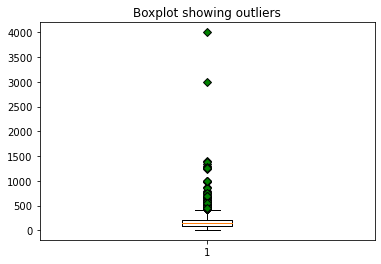

In [42]:
# Identify outliers in the dataset
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot showing outliers')
ax.boxplot(data['price'], flierprops=green_diamond)
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1 
outlier = Q3 + 1.5 *IQR

print ("Upper outlier=",outlier)

The boxplot shows that anything above 422.5 are outliers.

### Distribution of price data

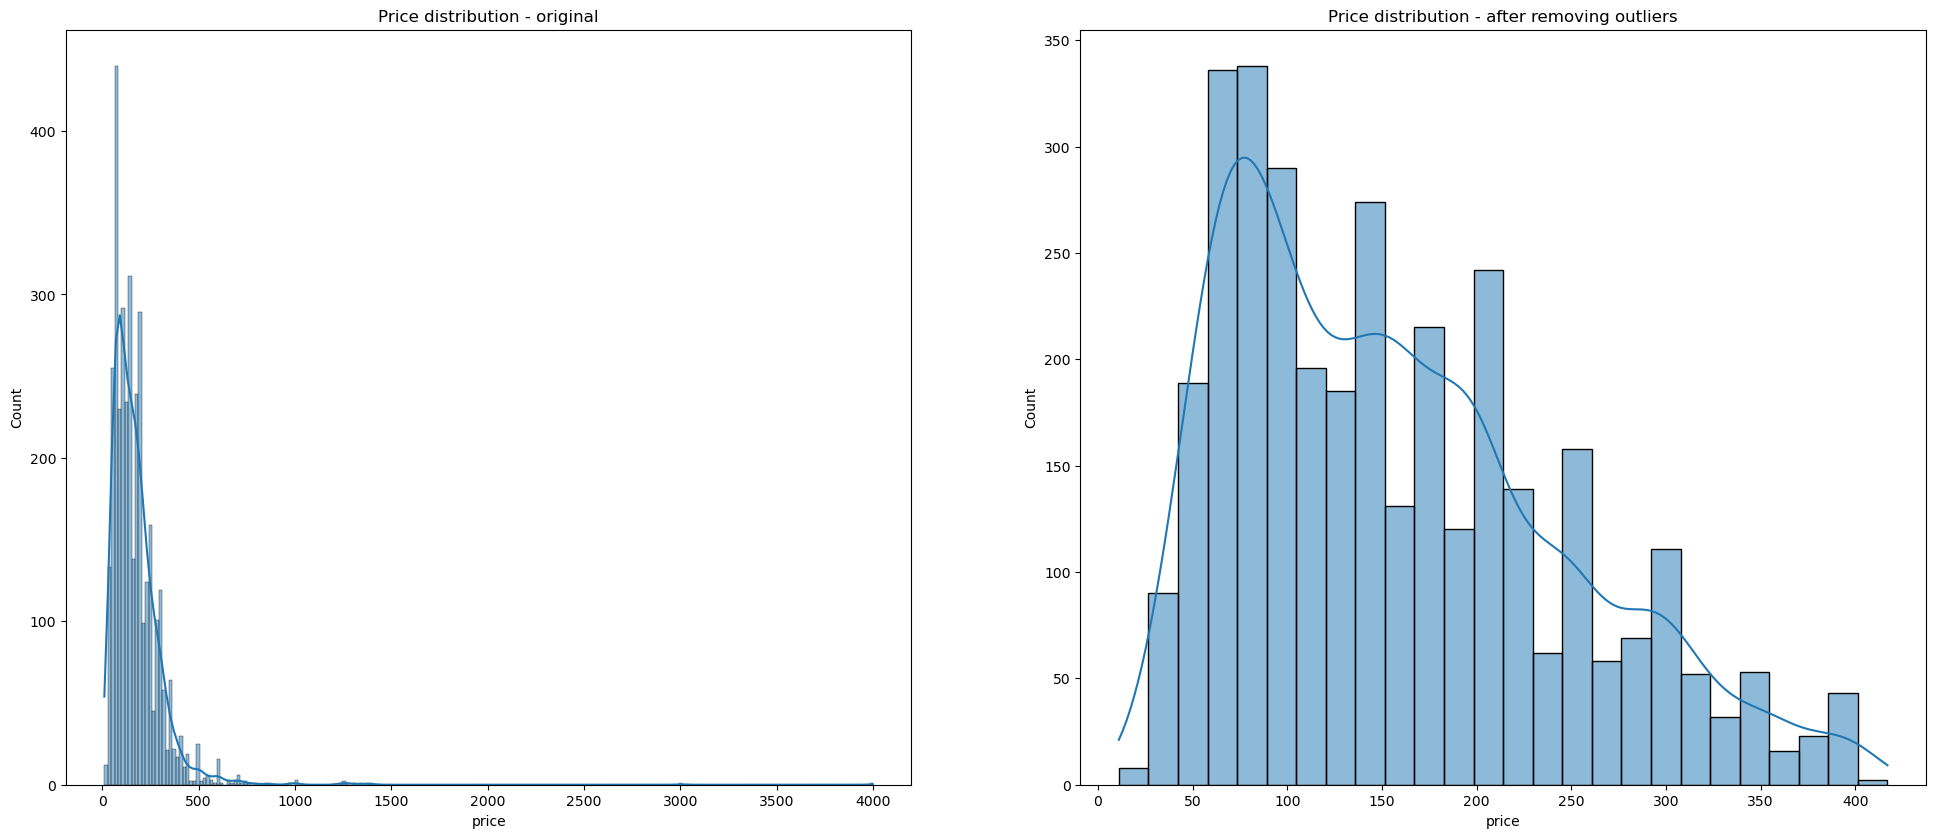

In [43]:
# histograms showing the distribution of listed prices
price_new = data[(data['price'] > 10) & (data['price'] < 423)]
fig, axs = plt.subplots(1, 2, figsize=(24, 10), dpi=100)
axs[0].set_title('Price distribution - original')
axs[1].set_title('Price distribution - after removing outliers')
sns.histplot(data['price'], kde=True, ax=axs[0])
sns.histplot(price_new['price'].astype(int), kde=True, ax=axs[1])
plt.show()

The diagrams show that the distribution of price data look improved after removing the outliers

### Correlation matrix of features

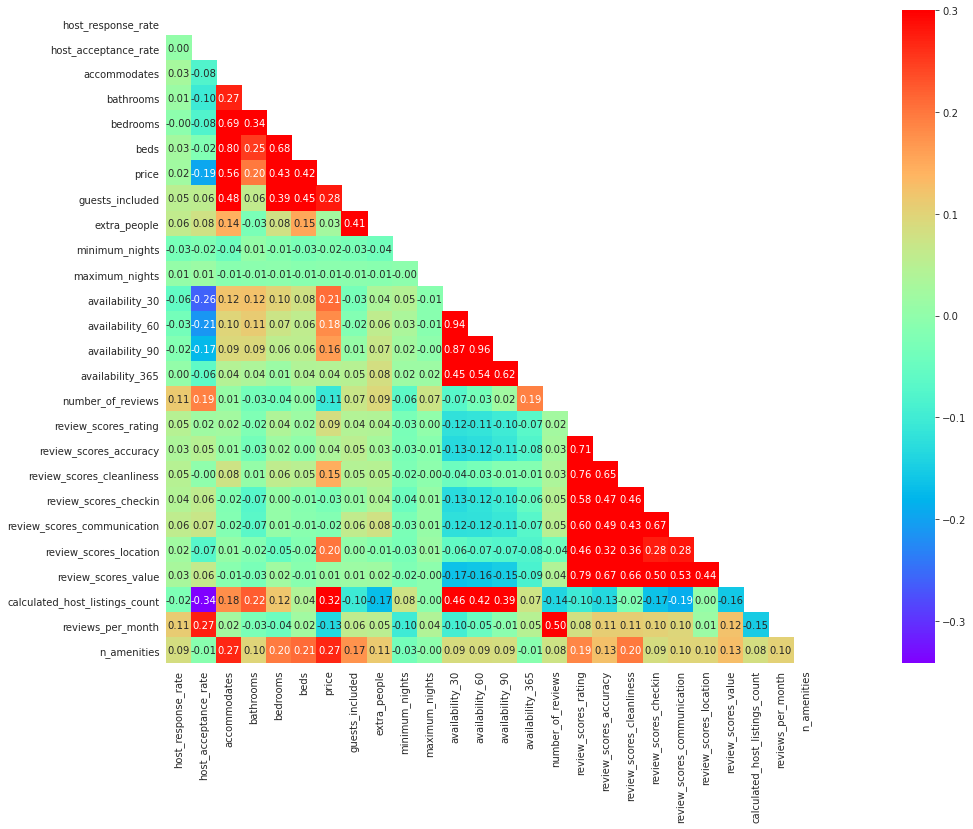

In [233]:
# visualize the correlation matrix, based on the data after removing outliers
r = price_new.corr()
mask = np.triu(np.ones(r.shape)).astype(np.bool)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(30, 12))
    ax = sns.heatmap(r, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f', cmap='rainbow')

We can observe that price is highly correlated with accommodates (number of people the property can accommodate), beds (number of beds), bathrooms (number of bathrooms)etc.

###  A glance at data of expensive properties

In [44]:
# Lets see how the very expensive units look like. We have noticed that accommodates and bedrooms are highly correlated with price
data_dp = list_clean.loc[:,['description', 'price','accommodates','bedrooms']]
high_price = data_dp[(data_dp['price'] > 1000)]
rooms = high_price.bedrooms.value_counts()
print ("summary of number of bedrooms\n", rooms)
accommodates = high_price.accommodates.value_counts()
print ("summary of number of accommodates\n",accommodates)

summary of number of bedrooms
 1    7
5    1
3    1
2    1
Name: bedrooms, dtype: int64
summary of number of accommodates
 4    3
2    3
8    1
5    1
3    1
1    1
Name: accommodates, dtype: int64


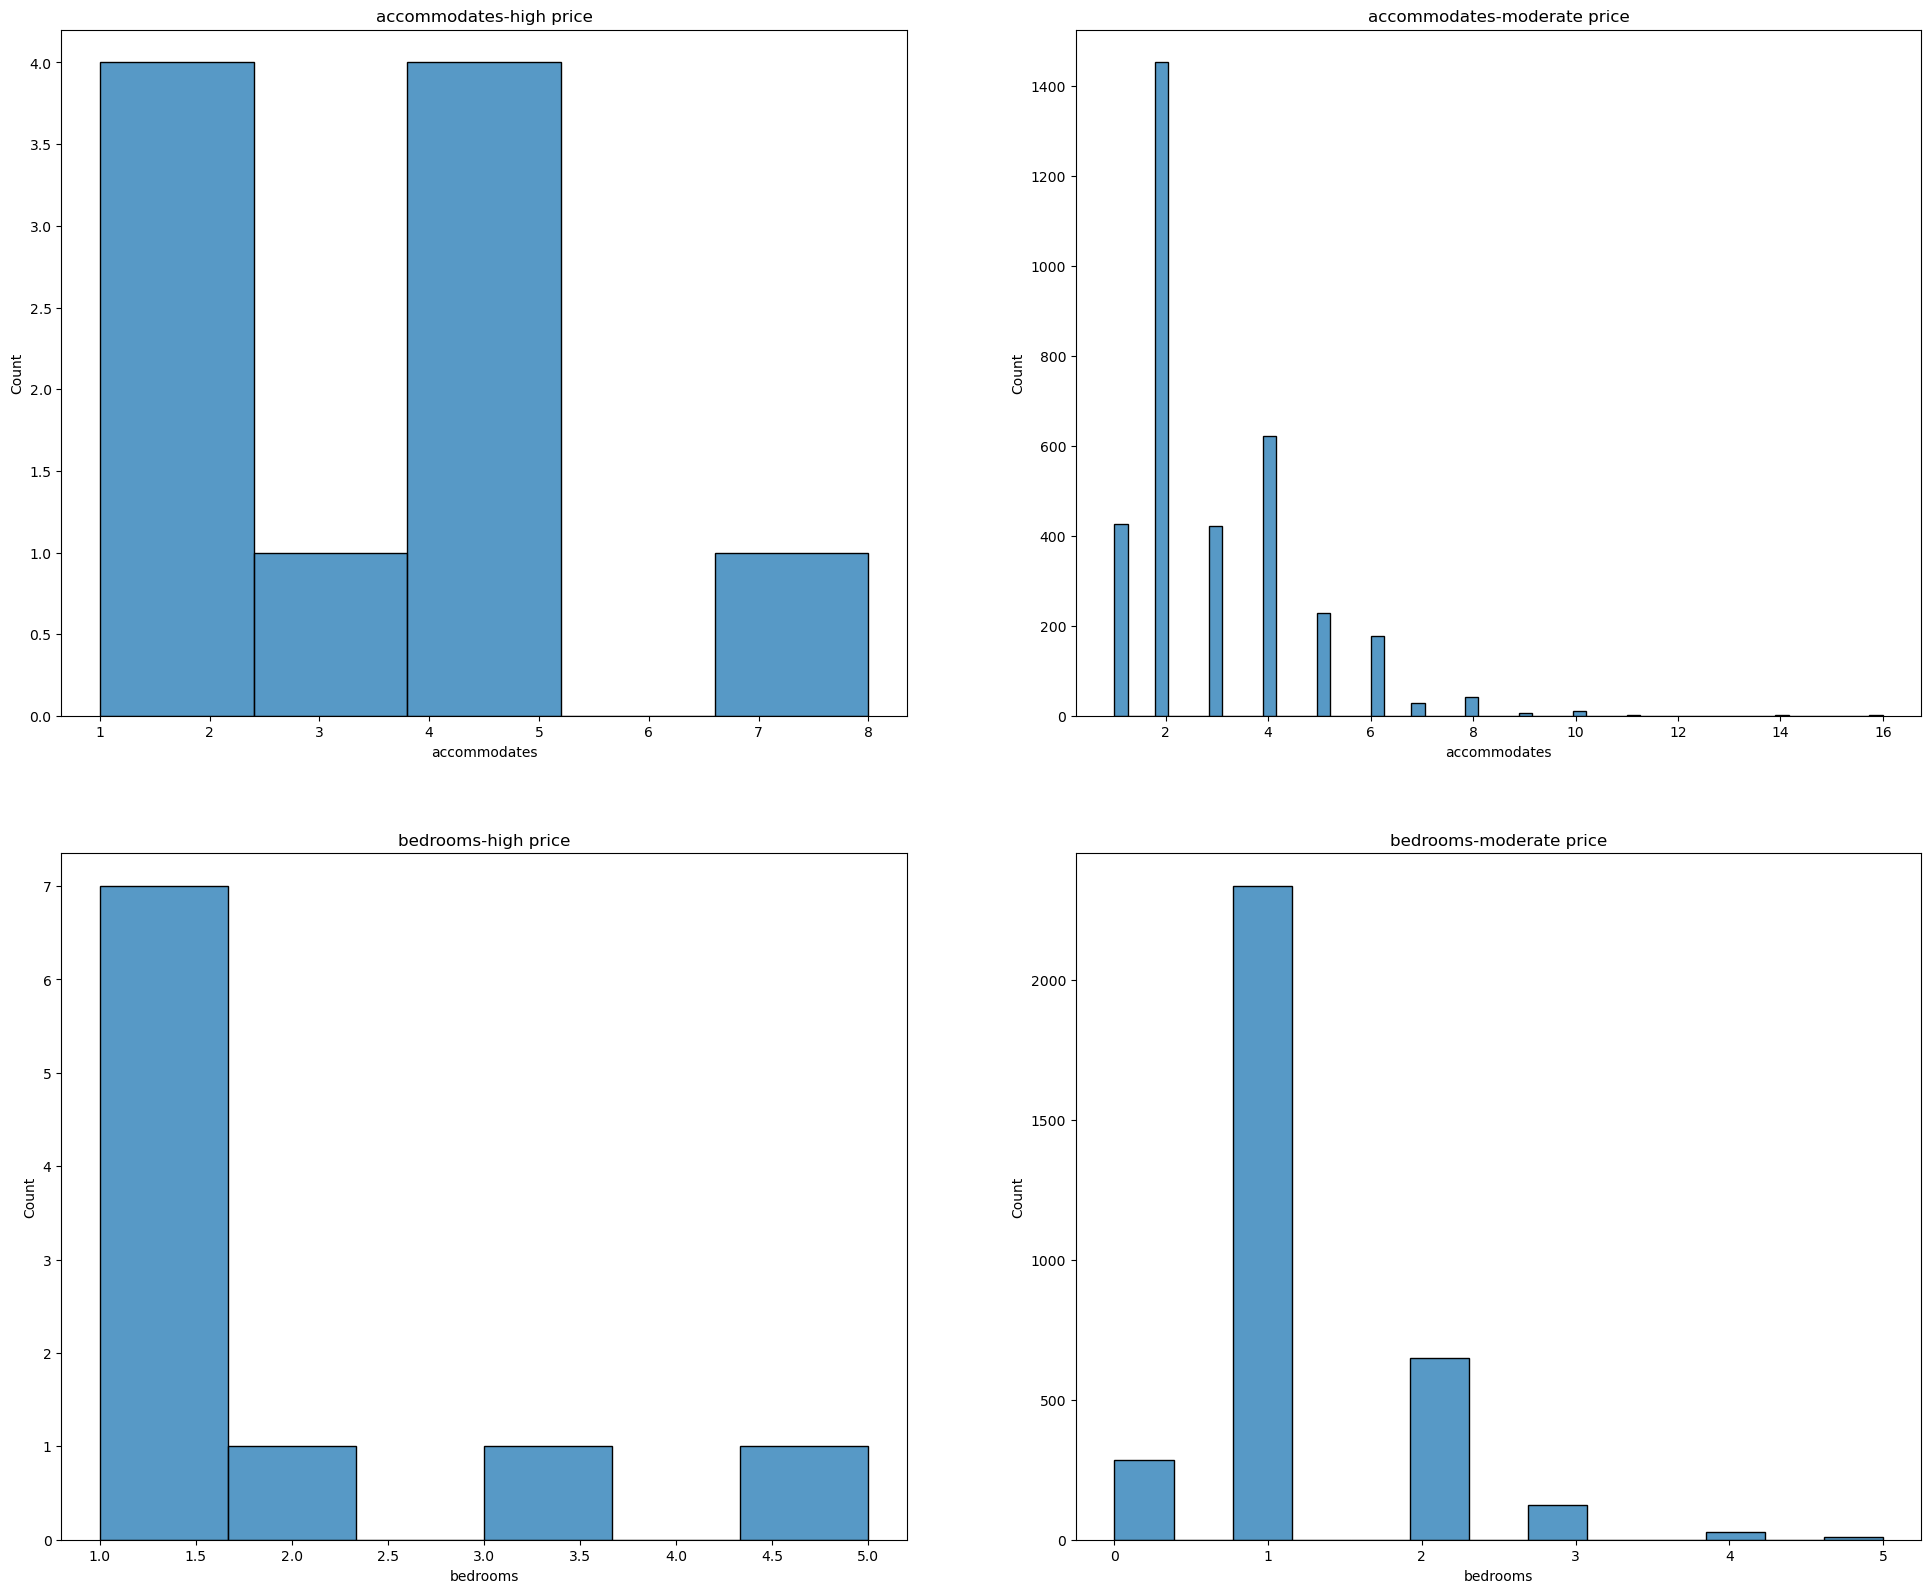

In [241]:
fig, axs = plt.subplots(2, 2, figsize=(24, 20), dpi=100)
axs[0][0].set_title('accommodates-high price')
axs[1][0].set_title('bedrooms-high price')
axs[0][1].set_title('accommodates-moderate price')
axs[1][1].set_title('bedrooms-moderate price')
sns.histplot(high_price['accommodates'], kde=False, ax=axs[0][0])
sns.histplot(high_price['bedrooms'].astype(int), kde=False, ax=axs[1][0])
sns.histplot(price_new['accommodates'], kde=False, ax=axs[0][1])
sns.histplot(price_new['bedrooms'].astype(int), kde=False, ax=axs[1][1])
plt.show()

It appears that some of the units are expensive because they have 3+ rooms and can accommodate 4+ people. 
But why some units only have 1 bedroom but are very expensive? Are they worth $1000+? This is beyond human brain. Let's use ML.

## 3. Modelling

### Preparing training data and test data

In [45]:
# seperate outliers from the data for now. Will investigate them later.
data_norm = data_ML[(data_ML['price'] > 10) & (data['price'] < 423)]
data_ex = data_ML[(data_ML['price'] > 423)]

In [46]:
# use data without outliers to build a ML model
X = data_norm.drop('price', axis=1)
y = data_norm['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2000)

### Use Lazy Predict to build quick models

In [149]:
# Lazy Predict help build a lot of basic models without much code and helps understand which models works better without any parameter tuning
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models_s = models.sort_values('RMSE',ascending=True)
print("Best five ML models are:")
print(models_s.iloc[:5])

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:28<00:00,  1.48it/s]

Best five ML models are:
                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
HistGradientBoostingRegressor                0.71       0.74 44.29        4.27
LGBMRegressor                                0.70       0.74 44.65        0.35
XGBRegressor                                 0.68       0.72 45.99        0.72
ExtraTreesRegressor                          0.68       0.72 46.22        3.09
RandomForestRegressor                        0.66       0.71 47.31        3.56


Looks like tree-based models give best result - I will stick to RF just because I like it. Of course we can try something else.

### Use random forest to build predictive model

In [51]:
# train and fit model
rf_model=RandomForestRegressor(n_estimators=1000,random_state=20)
rf_model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000, random_state=20)

In [65]:
# Evaluate model
y_pred=rf_model.predict(X_test)
def model_evaluate(rf_model, x_train, y_train, x_test, y_test):
    """This function calculates MAE, RMSE and R2"""
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred) 
    print('Mean Absolute Error:', mae,'\nRoot Mean Squared Error:', rmse,'\nR2:',r2)
print (model_evaluate.__doc__)
model_evaluate(rf_model, X_train, y_train, X_test, y_test)

This function calculates MAE, RMSE and R2
Mean Absolute Error: 32.5184133915575 
Root Mean Squared Error: 47.20757305223183 
R2: 0.7089943912663459


The RMSE is 47.2, which means we expect the difference between actual listing price and predicted price is ~$47.2. The R2 value shows that the model is able to explain ~71% variability in the price data .

<b>This figure answers Business Question 3</b>

### Model visulization

In [174]:
column_names = ["Tree_Number", "Max-Depth"]
tree_depth = pd.DataFrame(columns = column_names)
for i in range (1000):
    n = rf_model.estimators_[i].tree_.max_depth
    tree_depth = tree_depth.append({'Tree_Number': i, 'Max-Depth': n}, ignore_index=True)
tree_depth_s = tree_depth.sort_values('Max-Depth',ascending=True)
print("The tree with lowest max depth is:")
print(tree_depth_s.iloc[:1])

The tree with lowest max depth is:
    Tree_Number Max-Depth
642         642        29


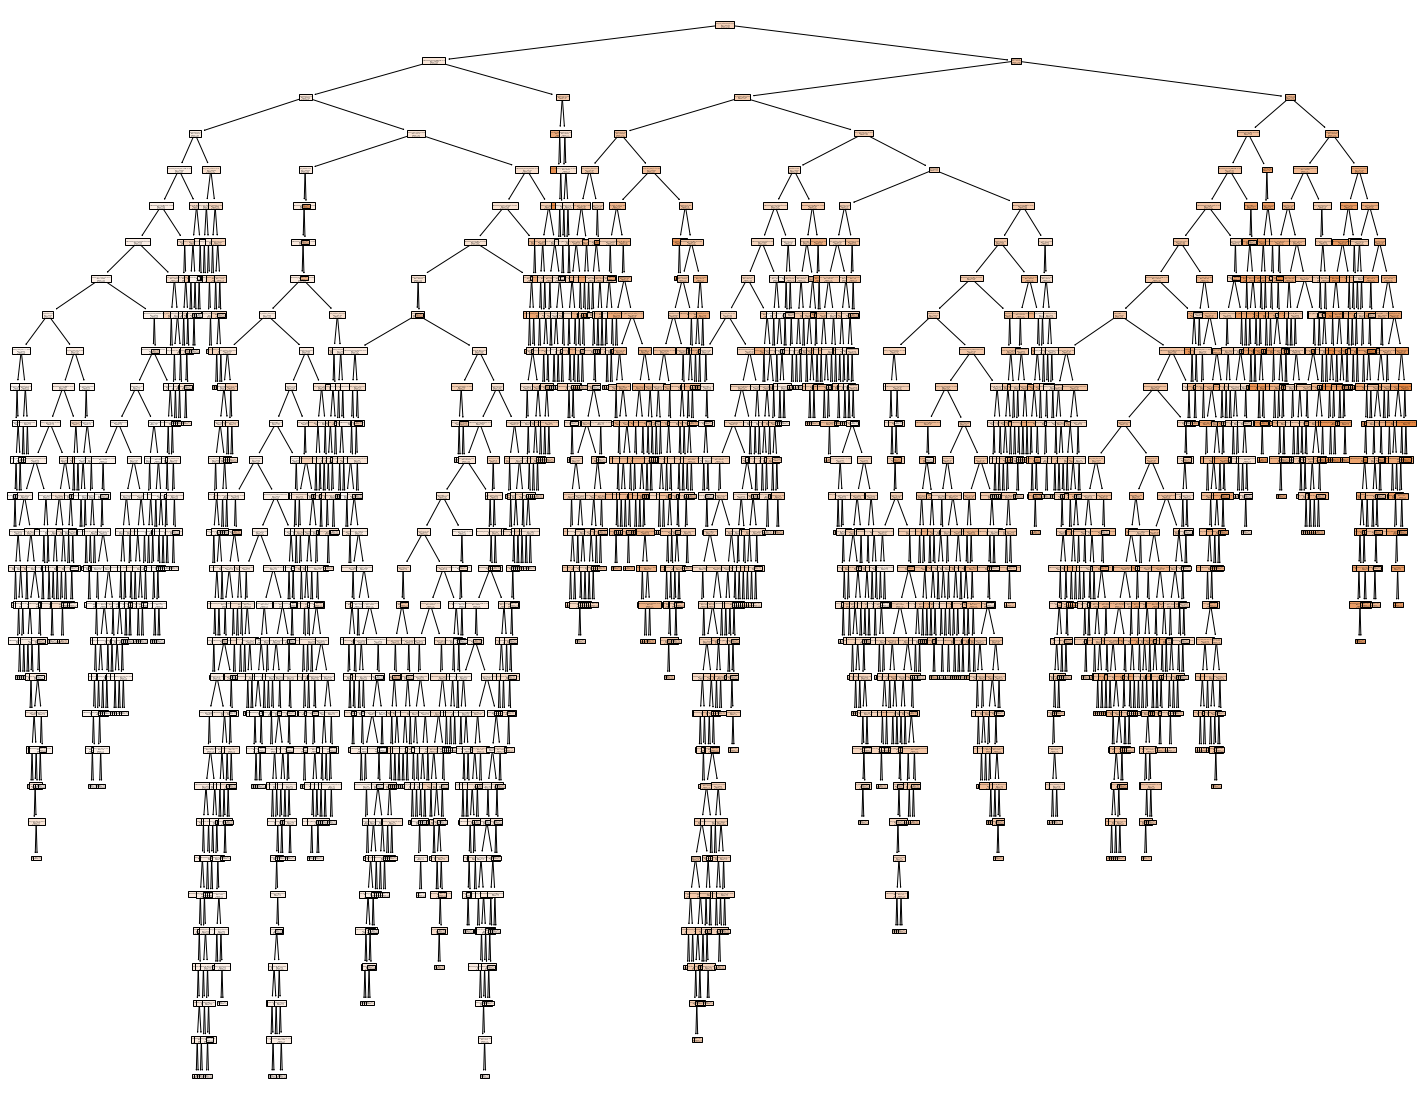

In [182]:
estimator = rf_model.estimators_[642]
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(estimator, feature_names=temp, filled=True)

OK great. Due to too large tree max depth, I cannot see anything. Let's leave it there for now.

### Feature importance assessment

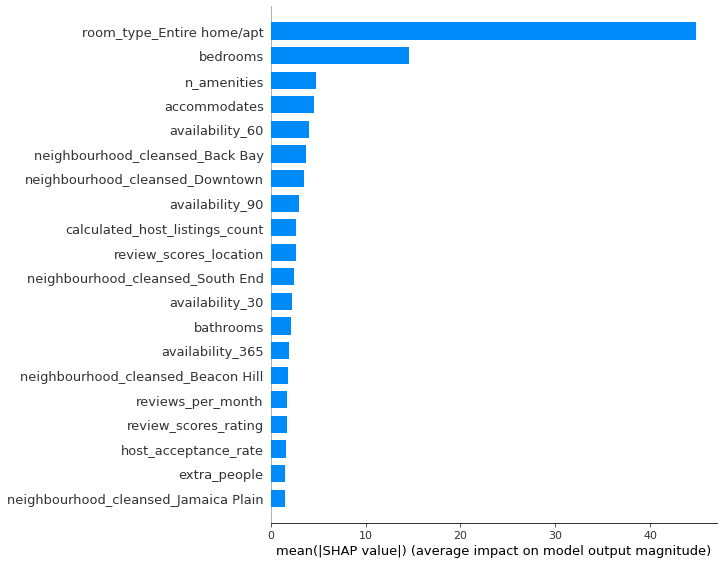

In [185]:
# Now lets take a look at the variable importance using SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Obviously the room type (entire home/apt), number of bedrooms and number of amenities have huge impact on the price.

<b>This figure answers Business Question 1</b>

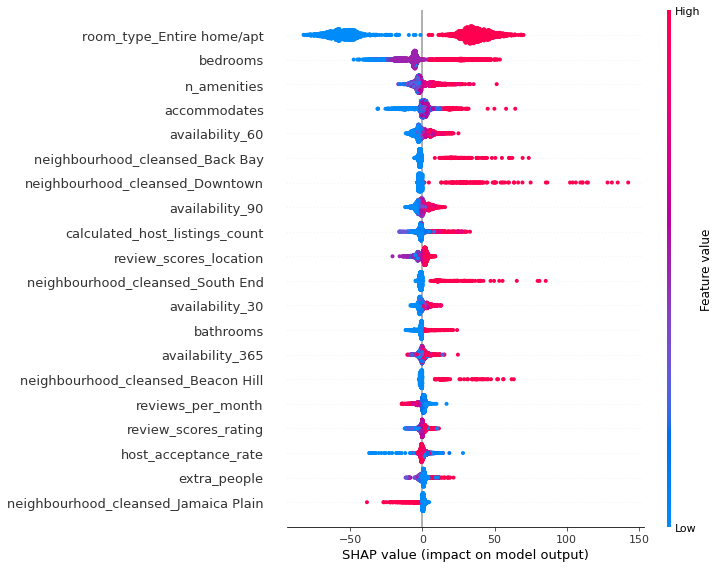

In [192]:
#Another SHAP figure
shap.summary_plot(shap_values, X_train)

It is easy to conclude that higher number in bedrooms, n_amenities, accommodates and availability_60 increases the price. If the property is a entire home/apartment, we should expect a high listing price. We can also observe that the properties in some of the neighborhoods, such as Back Bay, Downtown, Beacon Hill and South End, are likely to be expensive.

<b>This figure answers Business Question 2</b>

### Compare listing price and predicted price for expensive properties

Mean Absolute Error - Expensive units: 399.53981451612907
Statistics of (listed price - predicted price:) count    124.00
mean     399.54
std      448.36
min      114.37
25%      205.46
50%      287.76
75%      383.48
max     3775.61
Name: price, dtype: float64


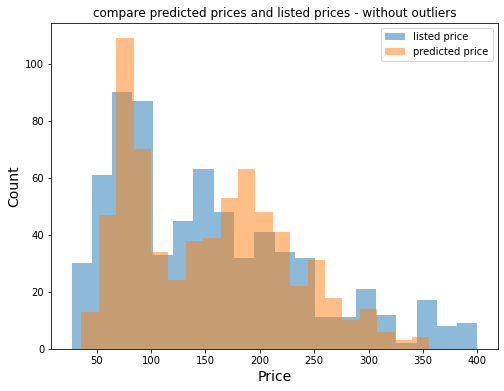

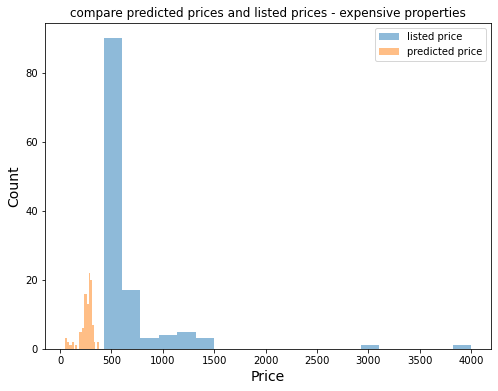

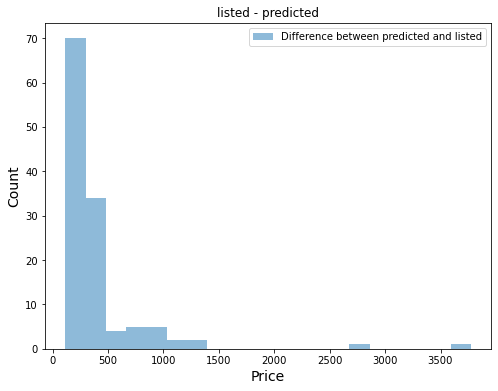

In [242]:
# Use the model to predict the very expensive units
data_ex_X = data_ex.drop('price', axis=1)
data_ex_Y = data_ex['price']
ex_pred=rf_model.predict(data_ex_X)
print('Mean Absolute Error - Expensive units:', mean_absolute_error(data_ex_Y, ex_pred))
# Distribution of redicted prices and listed prices - without outliers
plt.figure(figsize=(8,6))
plt.hist(y_test, bins=20, alpha=0.5, label="listed price")
plt.hist(y_pred, bins=20, alpha=0.5, label="predicted price")
plt.xlabel("Price", size=14)
plt.ylabel("Count", size=14)
plt.title("compare predicted prices and listed prices - without outliers")
plt.legend(loc='upper right')
# Distribution of redicted prices and listed prices - expensive properties
plt.figure(figsize=(8,6))
plt.hist(data_ex_Y, bins=20, alpha=0.5, label="listed price")
plt.hist(ex_pred, bins=20, alpha=0.5, label="predicted price")
plt.xlabel("Price", size=14)
plt.ylabel("Count", size=14)
plt.title("compare predicted prices and listed prices - expensive properties")
plt.legend(loc='upper right')
# Make plot for difference between listed price and predicted price
diff = data_ex_Y - ex_pred 
plt.figure(figsize=(8,6))
plt.hist(diff, bins=20, alpha=0.5, label="Difference between predicted and listed")
plt.xlabel("Price", size=14)
plt.ylabel("Count", size=14)
plt.title("listed - predicted")
plt.legend(loc='upper right')
print("Statistics of (listed price - predicted price:)",diff.describe())

Surprisingly, the RMSE is very high (399.5). As shown in Fig 8, for most of the properties, predicted prices are much lower than the listed price. The difference between predicted price and listed price ranges from 200 to 383. For one property, the difference is as large as 3,775.

### 4. Visualized interpretation for individual observation

In [67]:
# Extract data of property with price 4000
unit4k = data_ex[(data_ex['price'] == 4000)]
unit4k = unit4k.drop('price', axis=1)

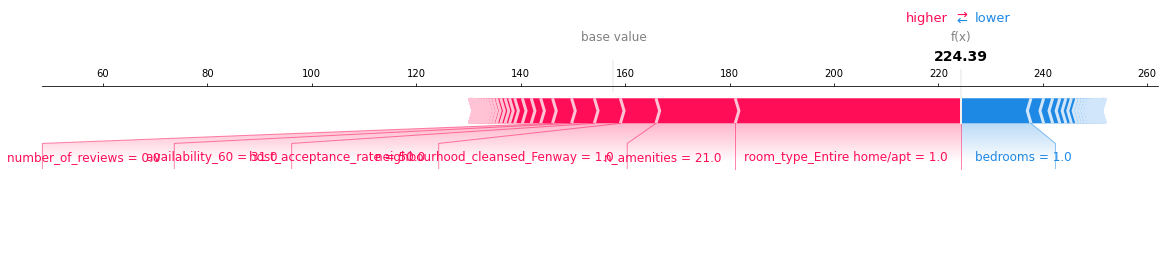

In [226]:
# Let's see how the model thinks about the unit at $4000 
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(unit4k)
shap.initjs()
shap_plot=shap.force_plot(explainer.expected_value[0], 
                          shap_values[0], highest,
                          matplotlib=True,show=False)

In [82]:
X_test

,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,minimum_nights,maximum_nights,...,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
2447,98.00,55.00,3.00,1,1,1,1,0.00,10,1125,...,1,0,0,0,1,0,1,0,1,0
487,90.00,75.00,1.00,1,1,1,1,20.00,1,1125,...,1,0,1,0,0,0,1,0,1,0
998,100.00,100.00,2.00,1,1,1,1,0.00,1,1125,...,1,0,1,0,0,0,1,0,1,0
1851,90.00,56.00,2.00,1,1,1,1,0.00,5,1125,...,1,0,0,0,1,0,1,0,1,0
2441,98.00,55.00,3.00,1,1,1,1,0.00,3,1125,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,100.00,56.00,3.00,1,2,2,3,50.00,1,1125,...,1,0,1,0,0,0,1,0,1,0
1163,100.00,50.00,2.00,1,1,1,1,0.00,5,14,...,1,0,1,0,0,0,1,0,1,0
2996,40.00,100.00,2.00,1,1,1,1,0.00,1,1125,...,0,1,1,0,0,0,1,0,1,0
1102,71.00,98.00,2.00,1,1,1,1,10.00,3,1125,...,0,1,0,0,1,0,1,0,1,0


Another surprise — the model predicts the price 224, which is much lower than the listed price. Fig 9 shows that the property is good for its room type (entire home/apartment), number of amenities (21) and neighborhood (Fenway). The bad thing is that the property has only one bedroom. Generally speaking, the model believes 4,000 is too high. 

<b>This figure answers Business Question 4</b>

The following functions can do SHAP plot for any observation based on your selection.

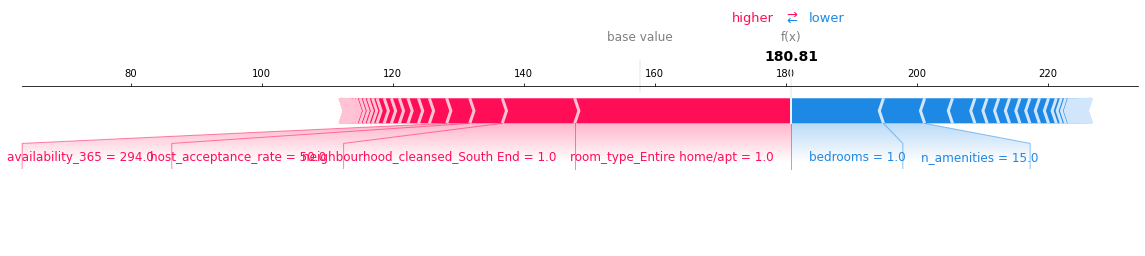

In [84]:
def shap_plot(j):
    """This function gives you shap plot for any observation"""
    choosen_instance = X_test.loc[[j]]
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(choosen_instance)
    shap.initjs()
    shap_plot=shap.force_plot(explainer.expected_value[0], 
                          shap_values[0], choosen_instance,
                          matplotlib=True,show=False)
# just use observation 1163 as an example
shap_plot(1163)